# CESM2-LE analysis of snow melt and runoff
## Mean State Change
- reading in ensemble of data from CESM2-LE, Rodgers et al 2021 ESD https://doi.org/10.5194/esd-2021-50
- Initial file IO from Daniel Kennedy djk2120@ucar.edu, modified Will Wieder wwieder@ucar.edu with improvements from Anderson Banihirwe abanihi@ucar.edu

### Looks at changes in the mean state from the forced response to SSP3-70 scenario
- Looks at changes in monthly data (precip, temperature, SWE, runoff, soil water, fire, etc), both averaged over the domain and for individual grid cells.

### Creates Figures
- Fig 1, Domain average seasonal cycle of relevent variables in baseline and SSP periods 
- Fig 2, S1 Domain maps of changes in relevent variables

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.17.0'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.06.2'

### Fetch cluster

In [4]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient(nmem='20GB')
cluster.scale(100)

In [6]:
# the extra workers can get stuck in the queue
cluster

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [7]:
#client.restart()

In [8]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [9]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths

In [10]:
def get_file(model,mem,field,year,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [11]:
def all_files(model,ens,field,firstyear,lastyear,freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [12]:
def get_data(model,ens,fields,preprocess,firstyear,lastyear,freq,chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,preprocess=preprocess,
                                    combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,preprocess=preprocess,
                                       combine='nested',parallel=True,
                                       concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [13]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    la.attrs['units'] = ds['area'].attrs['units']
    return la

In [14]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

--------------------
## Start editing here:
### Actually read in data

In [15]:
%%time
model = 'CESM2'
ens = 10+np.arange(40)
nens = len(ens)
# not sure why QRUNOFF won't read in correctly...
fields = ['H2OSNO','GPP','BTRANMN',
          'SOILWATER_10CM','QRUNOFF_TO_COUPLER',
          'QVEGT','QVEGE','QSOIL',
          'RAIN','SNOW','NBP','ELAI',
          'NFIRE','TBOT']#,'FAREA_BURNED']
firstyear = 1850
lastyear  = 2100
freq      = 'monthly'
preprocess = None

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = get_data(model,ens,fields,preprocess,firstyear,lastyear,freq).persist()
    _ = wait(ds)

print(ds.nbytes/1e9) #GB 

373.114873708
CPU times: user 4min 51s, sys: 8.55 s, total: 4min 59s
Wall time: 6min 4s


In [16]:
la = get_landarea(model)

In [17]:
%%time
# This may not be the right way to sum soil water by level?
# Need to weight by depth?
def preprocess(ds):
    '''sum over top 10 soil levels'''
    return ds.isel(levsoi=slice(0,10)).sum('levsoi')
fields = ['SOILLIQ','SOILICE']

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds2 = get_data(model,ens,fields,preprocess,firstyear,lastyear,freq).persist()
    _ = wait(ds2)    

print(ds2.SOILLIQ)
ds['SOILWATER'] = (ds2.SOILLIQ + ds2.SOILICE)
ds['SOILWATER'].attrs['long_name'] = 'soil water + ice (top 10 layers)'
ds['SOILWATER'].attrs['units'] = 'mm'
# 10ens = 53 GB, 1 minitue w/ 30 workers
# 20ens = 107 GB, 2.5 minitue w/ 30 workers

<xarray.DataArray 'SOILLIQ' (ens: 40, time: 3012, lat: 192, lon: 288)>
dask.array<concatenate, shape=(40, 3012, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * ens      (ens) int64 10 11 12 13 14 15 16 17 18 ... 42 43 44 45 46 47 48 49
CPU times: user 1min, sys: 1.78 s, total: 1min 2s
Wall time: 1min 32s


#### Mask out regions to be consistent with daily analyses

 -- Data mask read in -- 


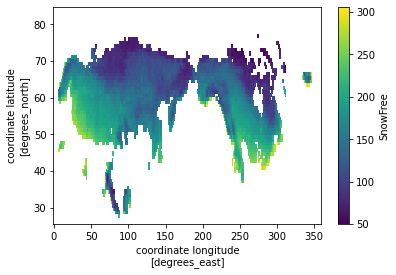

In [18]:
# we'll just look at 25-85 N for convenience
ds = ds.sel(lat=slice(25,85))
la = la.sel(lat=slice(25,85))

# use daily results to create mask
pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileIN =  pathIN + 'SnowStatsSWE*.nc'

dsMask = xr.open_mfdataset(fileIN,combine='nested',parallel=True, concat_dim=['ens'])
#dsMask = dsMask.MaxSnow.persist()
_ = wait(dsMask)

dsMask2 = dsMask['SnowFree'].isel(time=slice(0,10)).mean('time').max('ens')
dsMask2.plot()

ds = ds.where(dsMask2>=0)
la = la.where(dsMask2>=0)
print(' -- Data mask read in -- ')

#### Quick look at changes in fire counts

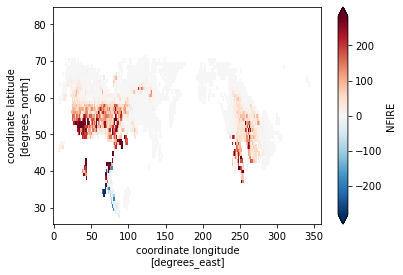

In [19]:
# counts / 1000 km^2 / y
meanFire0 = (ds.NFIRE.isel(time=slice((90*12),(120*12) )).sum('time').mean('ens')*365*24*3600*1e3)/30
meanFire = (ds.NFIRE.isel(time=slice((-30*12),None)).sum('time').mean('ens')*365*24*3600*1e3)/30
diffFire = meanFire - meanFire0
diffFire.where(meanFire>0).plot(robust=True) ;

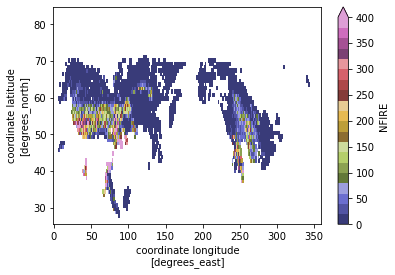

In [20]:
meanFire.where(meanFire>0).plot(vmax=400,vmin=0,cmap='tab20b');

### Convert to daily fluxes

In [21]:
s2d = 3600 * 24
ds['GPP'] = ds.GPP*s2d
ds['GPP'].attrs['units'] = 'gC $\mathregular{m^{-2}}$ $\mathregular{d^{-1}}$'
ds['GPP'].attrs['long_name'] = 'GPP'

ds['NBP'] = ds.NBP*s2d
ds['NBP'].attrs['units'] = 'gC/m2/d'
ds['NBP'].attrs['long_name'] = 'NBP'

ds['QRUNOFF'] = ds.QRUNOFF_TO_COUPLER*s2d
ds['QRUNOFF'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['QRUNOFF'].attrs['long_name'] = 'QRUNOFF'

ds['QVEGT'] = ds.QVEGT*s2d
ds['QVEGT'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['QVEGT'].attrs['long_name'] = 'QVEGT'

ds['QVEGE'] = ds.QVEGE*s2d
ds['QVEGE'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['QVEGE'].attrs['long_name'] = 'QVEGE'


ds['QSOIL'] = ds.QSOIL*s2d
ds['QSOIL'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['QSOIL'].attrs['long_name'] = 'QSOIL'

ds['SNOW'] = ds.SNOW*s2d
ds['SNOW'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['SNOW'].attrs['long_name'] = 'SNOW'

ds['RAIN'] = ds.RAIN*s2d
ds['RAIN'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['RAIN'].attrs['long_name'] = 'RAIN'

ds['NFIRE'] = ds.NFIRE*s2d*1000
ds['NFIRE'].attrs['units'] = '1000$\mathregular{km^{-2}}$ $\mathregular{d^{-1}}$'
ds['NFIRE'].attrs['long_name'] = 'Fire Counts'
# sum fluxes
ds['ET'] = ds.QVEGT + ds.QVEGE + ds.QSOIL
ds['ET'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['ET'].attrs['long_name'] = 'ET'

ds['PRECIP'] = (ds.RAIN+ds.SNOW)
ds['PRECIP'].attrs['units'] = 'mm $\mathregular{d^{-1}}$'
ds['PRECIP'].attrs['long_name'] = 'PRECIP'

ds['landarea'] = ds['area']*ds['landfrac']
ds['landarea'].name = 'landarea'
ds['landarea'].attrs['units'] = 'km2'

### Calculate water stress effect on GPP

In [22]:
ds['WUE'] = ds.GPP/ds.QVEGT
ds['WUE'].attrs['units'] = 'gC $\mathregular{kg^{-1}}$ H2O'
ds['WUE'].attrs['long_name'] = 'WUE'

ds['WaterStress'] = (1-ds['BTRANMN']) * ds['GPP']
ds['WaterStress'].attrs['units'] = ds['GPP'].attrs['units']
ds['WaterStress'].attrs['long_name'] = 'GPP * (1-BTRANMN)'

ds['ETfrac'] = ds.ET/(ds.ET+ds.QRUNOFF)
ds['ETfrac'] = ds['ETfrac'].where(ds.ETfrac<=1)
ds['ETfrac'].attrs['units'] = None
ds['ETfrac'].attrs['long_name'] = 'ET/(ET/Runoff)'

ds['SNOWfrac'] = ds.SNOW / ds.PRECIP
ds['SNOWfrac'].attrs['units'] = None
ds['SNOWfrac'].attrs['long_name'] = 'SNOW/PRECIP'

#### Climatology 1940-1969 vs. 2070-2099

In [23]:
IniClimo = ds.isel(time=slice((12*90),(12*120))).groupby("time.month").mean("time").compute()
FinClimo = ds.isel(time=slice((12*220),(12*250))).groupby("time.month").mean("time").compute()
#print(IniClimo.SNOWDP)

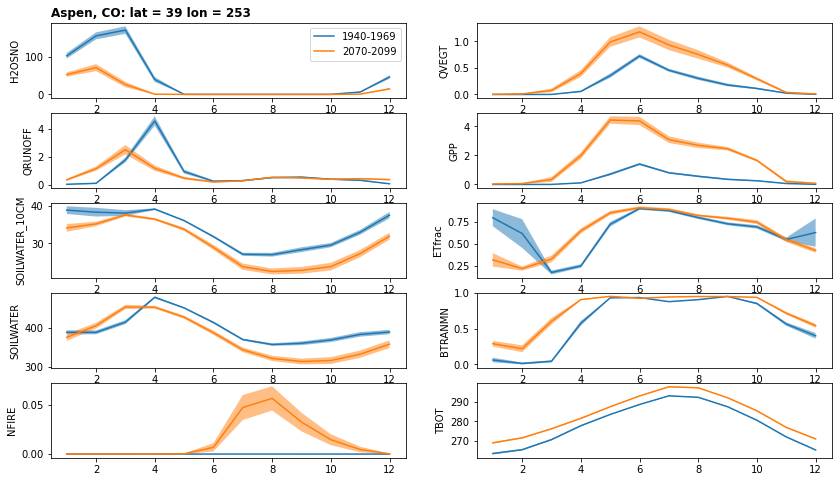

In [24]:
# organize plots
fields = ['H2OSNO','QVEGT',
          'QRUNOFF','GPP',
          'SOILWATER_10CM','ETfrac',
         'SOILWATER','BTRANMN',
         'NFIRE','TBOT']
plat, plon, site =  39 , 253  , 'Aspen, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =44.7, 360-115,'Frank Church Wilderness, ID'
#plat, plon, site =  50 , 60  , 'Random point' # try also 50,50
#plat, plon, site =  50 , 260  , 'Random point 2' 
#plat, plon, site =  60 , 250  , 'Random point 3' 
#plat, plon, site =  35 , 90  , 'Random point 4' 

IniPlot = IniClimo.sel(lat = plat, lon = plon, method='nearest')
FinPlot = FinClimo.sel(lat = plat, lon = plon, method='nearest')
plt.figure(figsize=[14,8])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(5,2,p)
    x = IniPlot.month
    y = IniPlot[fields[i]].mean('ens')
    y2 = (IniPlot[fields[i]]-y).std('ens')
    z  = FinPlot[fields[i]].mean('ens')
    z2 = (FinPlot[fields[i]]-z).std('ens')
    plt.plot(x,y)
    plt.fill_between(x, y - y2, y + y2, alpha=0.5)
    plt.plot(x,z)
    plt.fill_between(x, z - z2, z + z2, alpha=0.5)
    plt.ylabel(fields[i]) 
    if i == 0: 
        plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
        plt.legend(["1940-1969","2070-2099"])
    else: plt.title(" ") ;

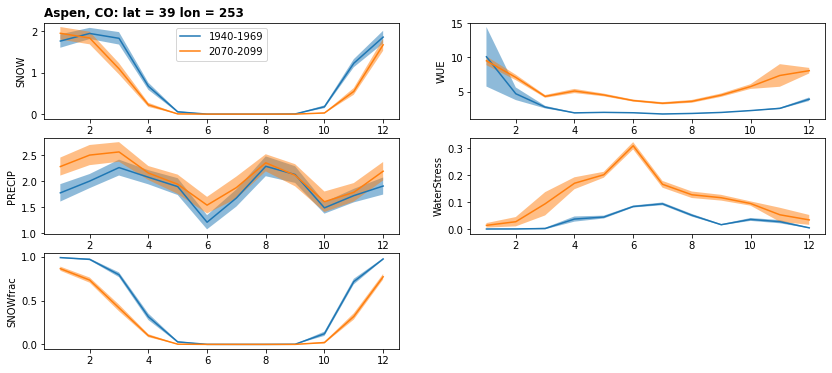

In [25]:
fields = ['SNOW','WUE',
          'PRECIP','WaterStress',
         'SNOWfrac']
plt.figure(figsize=[14,6])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(3,2,p)
    x = IniPlot.month
    y = IniPlot[fields[i]].mean('ens')
    y2 = (IniPlot[fields[i]]-y).std('ens')
    z  = FinPlot[fields[i]].mean('ens')
    z2 = (FinPlot[fields[i]]-z).std('ens')
    plt.plot(x,y)
    plt.fill_between(x, y - y2, y + y2, alpha=0.5)
    plt.plot(x,z)
    plt.fill_between(x, z - z2, z + z2, alpha=0.5)
    plt.ylabel(fields[i]) 
    if i == 0: 
        plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
        plt.legend(["1940-1969","2070-2099"])
    else: plt.title(" ") ;

### Repeat above globally 

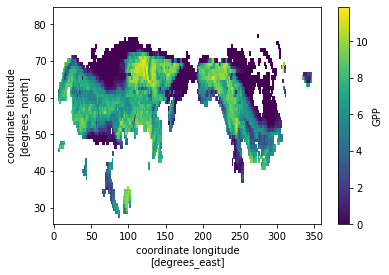

In [26]:
IniClimo.GPP.max(['month','ens']).plot(robust=False) ;

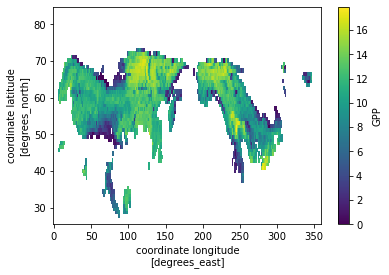

In [27]:
# MASK grids with max monthly gpp < 0.1 gC/m2/d
IniClimo = IniClimo.where(IniClimo.GPP.max(['month','ens']) > 0.1)
FinClimo = FinClimo.where(IniClimo.GPP.max(['month','ens']) > 0.1)
la = la.where(IniClimo.GPP.max(['month','ens']) > 0.1)
lawgt = (la/la.sum())

FinClimo.GPP.max(['month','ens']).plot() ;

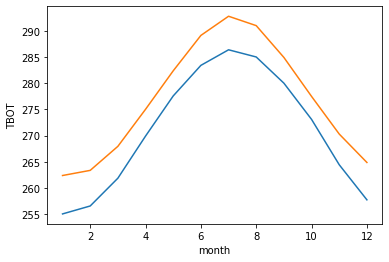

In [28]:
#IniClimo.TBOT.mean(['month','ens']).plot(robust=False) ;
#not weighted by land area
IniClimo.TBOT.mean(['ens']).mean(['lat','lon']).plot()
FinClimo.TBOT.mean(['ens']).mean(['lat','lon']).plot()

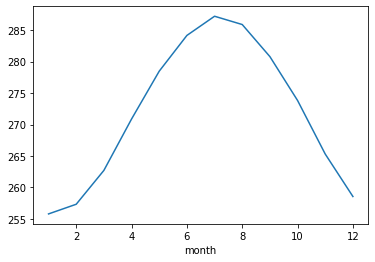

In [29]:
# Weighting seems to work fine!
test = IniClimo.TBOT.mean('ens') * lawgt
test = test.sum(skipna=True, dim=['lat','lon'])  #/ la.sum(skipna=True, dim=['lat','lon'])
test.plot() ;

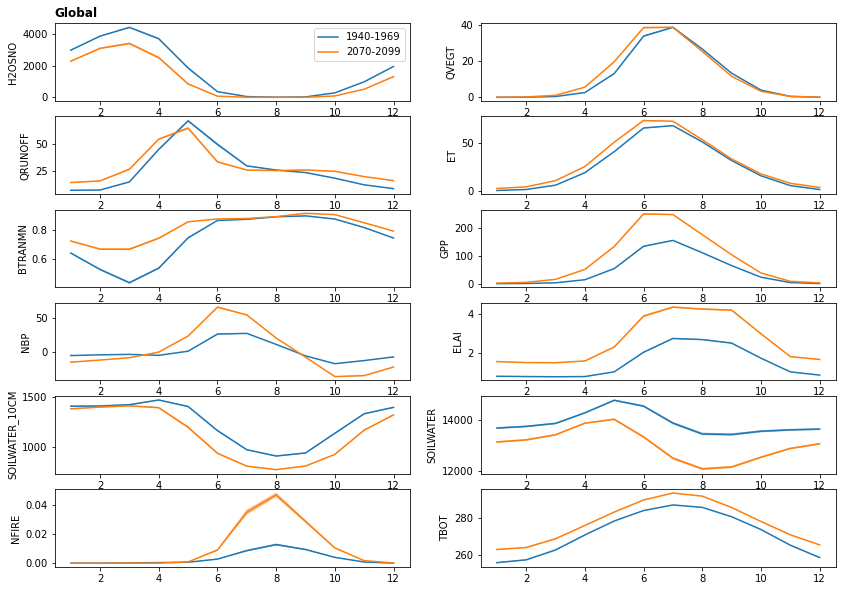

In [30]:
# sum across gridcells, weighting by landarea
# this will convert to PgC or TtH2O / day for each month
cf1 = 1e6    #km2-->m2
cf2 = 1e-12  #gC-->TgC and kgH2O-->MtH2O

IniPlotSum = ((cf1*IniClimo*la).sum(['lat','lon'])*cf2).persist()
FinPlotSum = ((cf1*FinClimo*la).sum(['lat','lon'])*cf2).persist()


IniPlotMean = (IniClimo*lawgt).sum(['lat','lon']).persist()
FinPlotMean = (FinClimo*lawgt).sum(['lat','lon']).persist()

fields = ['H2OSNO','QVEGT',
          'QRUNOFF','ET',
          'BTRANMN','GPP',
          'NBP','ELAI',
          'SOILWATER_10CM','SOILWATER',
         'NFIRE','TBOT']
mean = [False,False,False,False,
        True,False,False,True,
        False,False,True,True]

plt.figure(figsize=[14,10])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(6,2,p)
    x = IniPlotSum.month
    if mean[i] == False:
        y = IniPlotSum[fields[i]].mean('ens')
        y2 = (IniPlotSum[fields[i]]-y).std('ens')
        z  = FinPlotSum[fields[i]].mean('ens')
        z2 = (FinPlotSum[fields[i]]-z).std('ens')
    if mean[i] == True:
        y = IniPlotMean[fields[i]].mean('ens')
        y2 = (IniPlotMean[fields[i]]-y).std('ens')
        z  = FinPlotMean[fields[i]].mean('ens')
        z2 = (FinPlotMean[fields[i]]-z).std('ens')
    plt.plot(x,y)
    plt.fill_between(x, y - y2, y + y2, alpha=0.5)
    plt.plot(x,z)
    plt.fill_between(x, z - z2, z + z2, alpha=0.5)
    plt.ylabel(fields[i]) 
    if i == 0: 
        plt.title('Global', loc='left', fontsize='large', fontweight='bold') 
        plt.legend(["1940-1969","2070-2099"])
    else: plt.title(" ") ;

In [31]:
IniPlotSum

<xarray.Dataset>
Dimensions:             (ens: 40, levgrnd: 25, levlak: 10, month: 12)
Coordinates:
  * ens                 (ens) int64 10 11 12 13 14 15 16 ... 44 45 46 47 48 49
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/36)
    H2OSNO              (month, ens) float32 dask.array<chunksize=(12, 40), meta=np.ndarray>
    GPP                 (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    BTRANMN             (month, ens) float32 dask.array<chunksize=(12, 40), meta=np.ndarray>
    SOILWATER_10CM      (month, ens) float32 dask.array<chunksize=(12, 40), meta=np.ndarray>
    QRUNOFF_TO_COUPLER  (month, ens) float32 dask.array<chunksize=(12, 40), meta=np.ndarray>
    QVEGT               (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    ...                  ...
    PRECIP              (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    landarea            (month) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    WUE                 (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    WaterStress         (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    ETfrac              (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>
    SNOWfrac            (month, ens) float64 dask.array<chunksize=(12, 40), meta=np.ndarray>

### Nice plot of domain mean annual cycle

/glade/scratch/wwieder/VernalWindow/Fig1_DomainMean.pdf


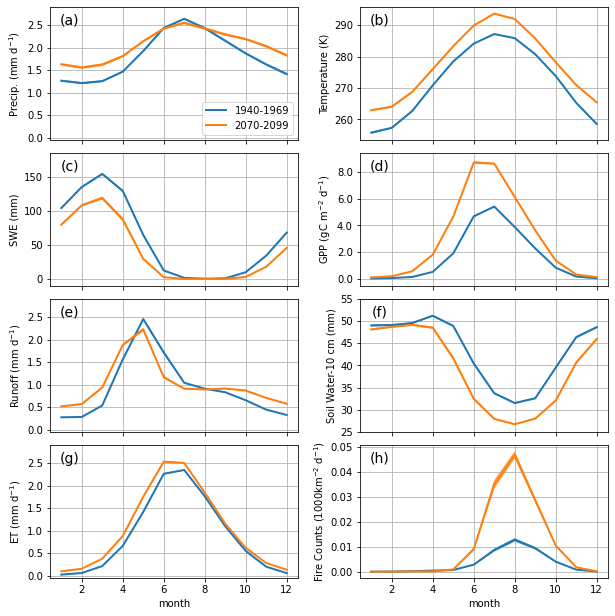

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job al

In [32]:
from matplotlib.ticker import FormatStrFormatter
ID = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
fields = ['PRECIP','TBOT','H2OSNO','GPP','QRUNOFF','SOILWATER_10CM','ET','NFIRE']
mean = [True,True,True,True,True,True,True,True]
ylab = ['Precip.','Temperature',
        'SWE','GPP',
        'Runoff','Soil Water-10 cm',
        'ET','Fire Counts']
fig, axs = plt.subplots(4, 2, sharex=True,
                        gridspec_kw={'wspace': 0.25, 'hspace':0.1},
                        figsize=(10,10.5))
p,q = 0,0
for i in range(len(fields)):
    #print(str(p)+', '+str(q))
    x = IniPlotSum.month
    if mean[i] == False:
        y = IniPlotSum[fields[i]].mean('ens')
        y2 = (IniPlotSum[fields[i]]-y).std('ens')
        z  = FinPlotSum[fields[i]].mean('ens')
        z2 = (FinPlotSum[fields[i]]-z).std('ens')
    if mean[i] == True:
        y = IniPlotMean[fields[i]].mean('ens')
        y2 = (IniPlotMean[fields[i]]-y).std('ens')
        z  = FinPlotMean[fields[i]].mean('ens')
        z2 = (FinPlotMean[fields[i]]-z).std('ens')
    axs[p,q].plot(x,y,linewidth=2)
    axs[p,q].fill_between(x, y - y2, y + y2, alpha=0.7)
    axs[p,q].plot(x,z,linewidth=2)
    axs[p,q].fill_between(x, z - z2, z + z2, alpha=0.7)
    axs[p,q].set_ylabel(ylab[i]+' ('+str(ds[fields[i]].attrs['units'])+')')
    #add panel label
    axs[p,q].annotate(ID[i], xy=(0.08, 0.9), xycoords=axs[p,q].transAxes,
                    ha='center', va='center',fontsize=14) 
    if fields[i] == 'PRECIP':
        axs[p,q].set_ylim(-0.05,2.9)
        axs[p,q].legend(["1940-1969","2070-2099"],frameon=True, loc=4)            
    if fields[i] == 'SOILWATER_10CM':
        axs[p,q].set_ylim(25,55)
        axs[p,q].set_ylabel(ylab[i]+' (mm)')
    if fields[i] == 'H2OSNO':
        axs[p,q].set_ylim(-10,185)
    if fields[i] == 'GPP':
        axs[p,q].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs[p,q].set_ylim(-0.5,9.4)
    if fields[i] == 'QRUNOFF' or fields[i] == 'ET':
        axs[p,q].set_ylim(-0.05,2.9)
    if i > 5:
        axs[p,q].set_xlabel('month')
    #if i == 3:
    #axs[p,q].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #axs[p,q].ticklabel_format(axis='y', style='sci', scilimits=(-2, 2), useOffset=False)
    
    axs[p,q].grid();
    q = q+1
    if q == 2:
        p = p+1
        q = 0

pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathIN + 'Fig1_DomainMean.pdf' 
print(fileOUT)
#plt.savefig(fileOUT) ;

/glade/scratch/wwieder/VernalWindow/Figx1_DomainMean_short.pdf


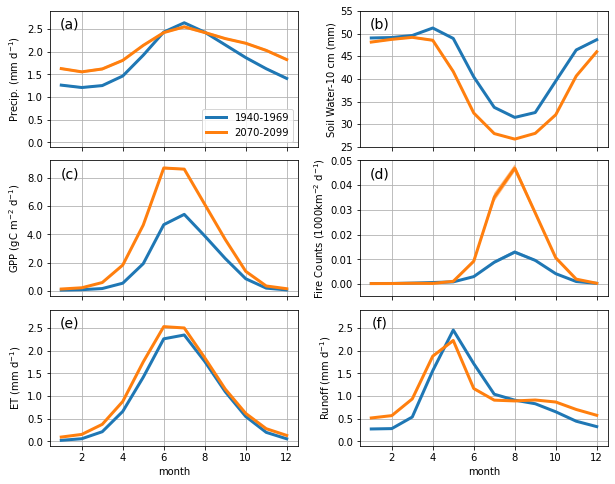

In [36]:
ID = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
fields = ['PRECIP','SOILWATER_10CM','GPP','NFIRE','ET','QRUNOFF']
#fields = ['SNOWfrac','ETfrac','NBP','BTRANMN']
mean = [True,True,True,True,True,True]
ylab = ['Precip.','Soil Water-10 cm',
        'GPP','Fire Counts',
        'ET','Runoff']
fig, axs = plt.subplots(3, 2, sharex=True,
                        gridspec_kw={'wspace': 0.25, 'hspace':0.1},
                        figsize=(10,8))
p,q = 0,0
for i in range(len(fields)):
    #print(str(p)+', '+str(q))
    x = IniPlotSum.month
    if mean[i] == False:
        y = IniPlotSum[fields[i]].mean('ens')
        y2 = (IniPlotSum[fields[i]]-y).std('ens')
        z  = FinPlotSum[fields[i]].mean('ens')
        z2 = (FinPlotSum[fields[i]]-z).std('ens')
    if mean[i] == True:
        y = IniPlotMean[fields[i]].mean('ens')
        y2 = (IniPlotMean[fields[i]]-y).std('ens')
        z  = FinPlotMean[fields[i]].mean('ens')
        z2 = (FinPlotMean[fields[i]]-z).std('ens')
    axs[p,q].plot(x,y,linewidth=3)
    axs[p,q].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[p,q].plot(x,z,linewidth=3)
    axs[p,q].fill_between(x, z - z2, z + z2, alpha=0.5)
    axs[p,q].set_ylabel(ylab[i]+' ('+str(ds[fields[i]].attrs['units'])+')')
    #add panel label
    axs[p,q].annotate(ID[i], xy=(0.08, 0.9), xycoords=axs[p,q].transAxes,
                    ha='center', va='center',fontsize=14) 
    if i == 0:
        axs[p,q].set_ylim(-0.1,2.9)
        axs[p,q].legend(["1940-1969","2070-2099"],frameon=True, loc=4)            
    if i ==1:
        axs[p,q].set_ylim(25,55)
        axs[p,q].set_ylabel(ylab[i]+' (mm)')
    if i ==2:
        axs[p,q].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #axs[p,q].set_ylim(-0.2,8.4)
    if i ==3:
        axs[p,q].set_ylim(-0.005,0.05)
    if i >3:
        axs[p,q].set_ylim(-0.1,2.9)
        axs[p,q].set_xlabel('month')
    #if i == 3:
    #axs[p,q].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #axs[p,q].ticklabel_format(axis='y', style='sci', scilimits=(-2, 2), useOffset=False)
    if i == 6: 
        axs[p,q].set_title('Global', loc='left',
                         fontdict= {'fontsize':'large', 'fontweight':'bold'}) 
    
    axs[p,q].grid();
    q = q+1
    if q == 2:
        p = p+1
        q = 0

pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathIN + 'Figx1_DomainMean_short.pdf' 
print(fileOUT)
plt.savefig(fileOUT) ;

* negative runoff in random point3 = irrigation?

----------------
* How to best aggregate these data?  
- create weighted WUE and BRANMN based on fraction of annual GPP in each month.
* Just look at July differences ?
* decadal climatology ?
* Regional changes?
* Could look at water yield too (annual runoff as fraction of total precip)
  * should thiis be done for annual water years instead?

In [37]:
### compute seasonal means
month_length = ds.time.isel(time=slice((12*90),(12*120))).dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))
# Calculate the weights by grouping by 'time.season'.
ini_weighted = (ds.isel(time=slice((12*90),(12*120))) * weights).groupby('time.season').sum(dim='time')

# repeat for end of simulation
month_length = ds.time.isel(time=slice((12*220),(12*250))).dt.days_in_month
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()
fin_weighted = (ds.isel(time=slice((12*220),(12*250))) * weights).groupby('time.season').sum(dim='time')

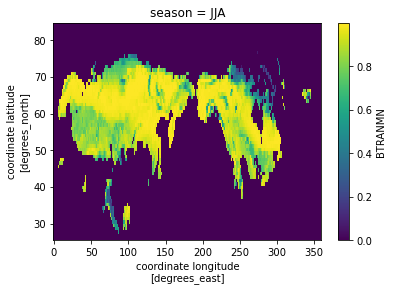

In [38]:
fin_weighted.BTRANMN.isel(season=1).mean('ens').plot() ;

### Calculate annual means

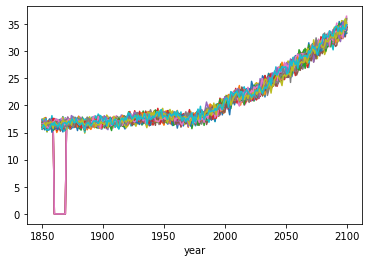

In [39]:
#compute annual total GPP
nyears  = len(np.unique(ds['time.year']))
#cf = 24*60*60           # used to convert /s to /d
dpm = month_wts(nyears) # days per month
gpp_ann = (dpm*ds.GPP).groupby('time.year').sum(skipna=True) 

# sum across gridcells, weighting by landarea
cf1 = 1e6    #km2-->m2
cf2 = 1e-15  #gC-->PgC and kgH2O-->TtH2O
gpp_ann_glob = (cf1*ds.landarea*gpp_ann).sum(dim=['lat','lon']) * cf2
gpp_ann_glob.plot(hue='ens', x='year',add_legend=False) ;

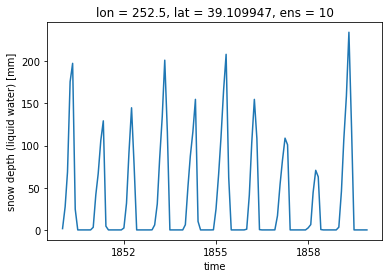

In [40]:
ds.shift(time=-10).H2OSNO.sel(lat = plat, lon = plon, method='nearest'
                            ).isel(ens=0,time=slice(0,120)).plot() ;

### Shift annual fluxes to water year 

In [41]:
ann_var   = ['GPP'    ,'QRUNOFF',
             'PRECIP' ,'QVEGT'  ,
             'WaterStress',
             'SNOW', 'ET',
             'SOILWATER_10CM','SOILWATER',
            'NFIRE']
ann_units = ['gC/m2/y','mm $\mathregular{y^{-1}}$'   ,
             'mm $\mathregular{y^{-1}}$','mm $\mathregular{y^{-1}}$',
             'gC/m2/y'    ,
             'mm $\mathregular{y^{-1}}$', 'mm $\mathregular{y^{-1}}$',
             'mm','mm',
            '1000 $\mathregular{km^{-2}}$ $\mathregular{y^{-1}}$']
glob_units= ['PgC/y'  ,'TtH2O/y','TtH2O/y','TtH2O/y','PgC/y'   ,
             'TtH2O/y','TtH2O/y','TtH2O','TtH2O','counts/y']
ds_ann  = xr.Dataset(coords = gpp_ann.coords)
ds_ann_glob = xr.Dataset(coords = gpp_ann_glob.coords)
dsShift = ds.shift(time=-10)
dpmShift = dpm.shift(time=-10)

for i in range(len(ann_var)):
    if ann_var[i] == 'SOILWATER_10CM':
        ds_ann[ann_var[i]] = ((dpmShift*dsShift[ann_var[i]]).groupby('time.year').sum(skipna=True)/
                              365).persist() 
        ds_ann_glob[ann_var[i]] = cf1*cf2*(ds.landarea*ds_ann[ann_var[i]]).sum(dim=['lat','lon'])
    elif ann_var[i] == 'NFIRE':  #check units here, ds.NFIRE = counts/1e3km2/d
        ds_ann[ann_var[i]] = (dpmShift*dsShift[ann_var[i]]).groupby('time.year').sum(skipna=True).persist() 
        ds_ann_glob[ann_var[i]] = (ds.landarea*1e-3*ds_ann[ann_var[i]]).sum(dim=['lat','lon']) 
    else:
        ds_ann[ann_var[i]] = (dpmShift*dsShift[ann_var[i]]).groupby('time.year').sum(skipna=True).persist() 
        ds_ann_glob[ann_var[i]] = cf1*cf2*(ds.landarea*ds_ann[ann_var[i]]).sum(dim=['lat','lon'])
    
    # add attributes    
    ds_ann[ann_var[i]].attrs['long_name'] = ann_var[i]
    ds_ann[ann_var[i]].attrs['units'] = ann_units[i]

    ds_ann_glob[ann_var[i]].attrs['long_name'] = ann_var[i]
    ds_ann_glob[ann_var[i]].attrs['units'] = glob_units[i]
    print('  finished annual sums '+ann_var[i])

print('--')

  finished annual sums GPP
  finished annual sums QRUNOFF
  finished annual sums PRECIP
  finished annual sums QVEGT
  finished annual sums WaterStress
  finished annual sums SNOW
  finished annual sums ET
  finished annual sums SOILWATER_10CM
  finished annual sums SOILWATER
  finished annual sums NFIRE
--


In [42]:
## get rid of last water year that's incomplete
ds_ann = ds_ann.isel(year=slice(0,-1))
ds_ann_glob = ds_ann_glob.isel(year=slice(0,-1))
ds_ann

,Array,Chunk
Bytes,1.35 GiB,141.75 kiB
Shape,"(250, 40, 63, 288)","(1, 1, 63, 288)"
Count,20040 Tasks,10000 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.35 GiB,141.75 kiB
Shape,"(250, 40, 63, 288)","(1, 1, 63, 288)"
Count,20040 Tasks,10000 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


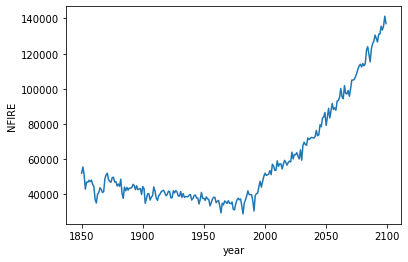

In [43]:
#ds_ann['NFIRE'].attrs['units'] = 'counts 1000 $\mathregular{km^{-2 }}$ $\mathregular{y^{-1}}'
ds_ann_glob.NFIRE.mean('ens').plot() ;

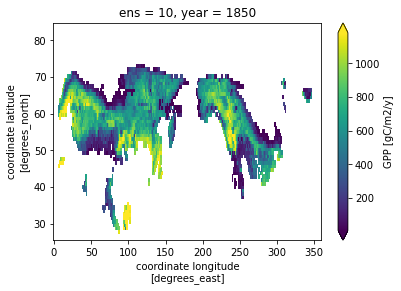

In [44]:
## mask out regions w/ very low initial GPP
minGPP = 10
ds_ann = ds_ann.where(
    ds_ann['GPP'].isel(year=slice(0,30)).mean(['ens','year'])>minGPP
)
ds_ann['GPP'].isel(ens=0,year=0).plot(robust=True) ;

# get rid of data on last time point
ds_ann = ds_ann.where(ds_ann.year<2100)

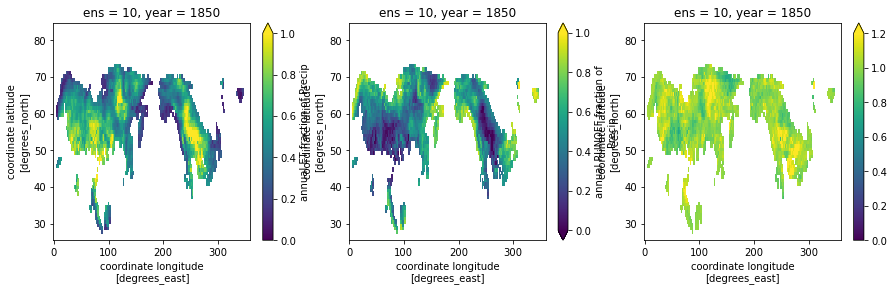

In [45]:
## Calculate derived variables for fraction of precip lost to ET vs. Runoff
## NOTE, this should likely be done for water years...
ds_ann['ET_frac'] = ds_ann.ET/ds_ann.PRECIP
ds_ann['ET_frac'].attrs['long_name'] = 'annual ET fraction of Precip'
ds_ann['ET_frac'].attrs['units'] = None

ds_ann['Run_frac'] = ds_ann.QRUNOFF/ds_ann.PRECIP
ds_ann['Run_frac'].attrs['long_name'] = 'annual RUNOFF fraction of Precip'
ds_ann['Run_frac'].attrs['units'] = None
plt.figure(figsize=[15,4])

plt.subplot(131)
ds_ann['ET_frac'].isel(ens=0,year=0).plot(robust=True,vmax=1,vmin=0)
plt.subplot(132)
ds_ann['Run_frac'].isel(ens=0,year=0).plot(robust=True,vmax=1,vmin=0)
plt.subplot(133)
(ds_ann['ET_frac']+ds_ann['Run_frac']).isel(ens=0,year=0).plot(robust=True,vmax=1.2,vmin=0) ;


#### Test creating a weighting function based on GPP
- Monthly GPP / annual sum

Skip this for now

In [46]:
'''plat, plon, site =  39 , 253  , 'Aspen, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

ee = 0
coords = ds.GPP.isel(ens=ee).coords
GPPann = ds_ann['GPP'].isel(ens=ee)
GPPwgt = xr.DataArray(np.repeat(
    GPPann.values,12,axis=0),coords=coords).chunk({'time':120})

GPPmon = (ds['GPP'].isel(ens=ee)*dpm).chunk({'time':120}) 
GPPwgt = GPPmon / GPPwgt
GPPwgt.sel(
    lat = plat, lon = plon, method='nearest'
).isel(time=slice(0,120)).plot() ;'''

"plat, plon, site =  39 , 253  , 'Aspen, CO' \n#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'\n\nee = 0\ncoords = ds.GPP.isel(ens=ee).coords\nGPPann = ds_ann['GPP'].isel(ens=ee)\nGPPwgt = xr.DataArray(np.repeat(\n    GPPann.values,12,axis=0),coords=coords).chunk({'time':120})\n\nGPPmon = (ds['GPP'].isel(ens=ee)*dpm).chunk({'time':120}) \nGPPwgt = GPPmon / GPPwgt\nGPPwgt.sel(\n    lat = plat, lon = plon, method='nearest'\n).isel(time=slice(0,120)).plot() ;"

In [47]:
'''temp = GPPwgt*ds.BTRANMN.isel(ens=ee)
temp.sel(
    lat = plat, lon = plon, method='nearest'
).groupby('time.year').sum().plot() ;'''

"temp = GPPwgt*ds.BTRANMN.isel(ens=ee)\ntemp.sel(\n    lat = plat, lon = plon, method='nearest'\n).groupby('time.year').sum().plot() ;"

In [48]:
## This is too slow, and not useful...
'''# try annual values weighted by GPP fraction/month 
ann_wgt   = ['SOILWATER_10CM','SOILWATER','WUE' ,'BTRANMN']
# to avoid overloading memory need to loop through this
for ee in range(nens): 
    print('starting ensemble '+str(ee))
    coords = ds.GPP.isel(ens=ee).coords
    GPPann = ds_ann['GPP'].isel(ens=ee)
    GPPwgt = xr.DataArray(np.repeat(
        GPPann.values,12,axis=0),coords=coords).chunk({'time':120})

    GPPmon = (ds['GPP'].isel(ens=ee)*dpm).chunk({'time':120}) 
    GPPwgt = GPPmon / GPPwgt
    
    temp0 = (GPPwgt*ds.WUE.isel(ens=ee)).groupby('time.year').sum(skipna=True) 
    temp1 = (GPPwgt*ds.BTRANMN.isel(ens=ee)).groupby('time.year').sum(skipna=True) 
    temp2 = (GPPwgt*ds.SOILWATER_10CM.isel(ens=ee)).groupby('time.year').sum(skipna=True) 
    temp3 = (GPPwgt*ds.SOILWATER.isel(ens=ee)).groupby('time.year').sum(skipna=True) 

    if ee == 0 : 
        WUE = temp0.persist()
        BTRANMN = temp1.persist()
        SOILWATER_10CM = temp2.persist()
        SOILWATER = temp3.persist()
    else: 
        WUE = xr.concat([WUE, temp0], dim='ens').persist()
        BTRANMN = xr.concat([BTRANMN, temp1], dim='ens').persist()
        SOILWATER_10CM = xr.concat([SOILWATER_10CM, temp2], dim='ens').persist()
        SOILWATER = xr.concat([SOILWATER, temp3], dim='ens').persist()
        
    _ = wait(SOILWATER) 

# load everything into a dataset    
ann_wgt   = ['SOILWATER_10CMwgt','SOILWATERwgt','WUEwgt'  ,'BTRANMNwgt']
ds_ann_wgt  = xr.Dataset(coords = gpp_ann.coords)
ds_ann_wgt['WUEwgt'] = WUE
ds_ann_wgt['BTRANMNwgt'] = BTRANMN
ds_ann_wgt['SOILWATER_10CMwgt'] = SOILWATER_10CM
ds_ann_wgt['SOILWATERwgt'] = SOILWATER
ds_ann_wgt = ds_ann_wgt.where(ds_ann_wgt.year<2100)
print('-- Finished! --')'''

"# try annual values weighted by GPP fraction/month \nann_wgt   = ['SOILWATER_10CM','SOILWATER','WUE' ,'BTRANMN']\n# to avoid overloading memory need to loop through this\nfor ee in range(nens): \n    print('starting ensemble '+str(ee))\n    coords = ds.GPP.isel(ens=ee).coords\n    GPPann = ds_ann['GPP'].isel(ens=ee)\n    GPPwgt = xr.DataArray(np.repeat(\n        GPPann.values,12,axis=0),coords=coords).chunk({'time':120})\n\n    GPPmon = (ds['GPP'].isel(ens=ee)*dpm).chunk({'time':120}) \n    GPPwgt = GPPmon / GPPwgt\n    \n    temp0 = (GPPwgt*ds.WUE.isel(ens=ee)).groupby('time.year').sum(skipna=True) \n    temp1 = (GPPwgt*ds.BTRANMN.isel(ens=ee)).groupby('time.year').sum(skipna=True) \n    temp2 = (GPPwgt*ds.SOILWATER_10CM.isel(ens=ee)).groupby('time.year').sum(skipna=True) \n    temp3 = (GPPwgt*ds.SOILWATER.isel(ens=ee)).groupby('time.year').sum(skipna=True) \n\n    if ee == 0 : \n        WUE = temp0.persist()\n        BTRANMN = temp1.persist()\n        SOILWATER_10CM = temp2.persist(

#### Add weighted annual data to ds_ann

In [49]:
'''ann_wgt = ['SOILWATER_10CM','SOILWATER','WUE'  ,'BTRANMN']
ann_wgt2 = ['SOILWATER_10CMwgt','SOILWATERwgt','WUEwgt' ,'BTRANMNwgt']
## add attributes and make a quick plot of trends
plt.figure(figsize=[6,10])
for i in range(len(ann_wgt)):
    ds_ann_wgt[ann_wgt2[i]].attrs = ds[ann_wgt[i]].attrs
    plt.subplot(5,1,(i+1))
    ds_ann_wgt[ann_wgt2[i]].sel(lat = plat, lon = plon, method='nearest').mean('ens').plot()
    if i > 0: plt.title(None)


plt.subplot(5,1,5)
ds_ann.PRECIP.sel(lat = plat, lon = plon, method='nearest').mean('ens').plot()
plt.title(None) ;'''

"ann_wgt = ['SOILWATER_10CM','SOILWATER','WUE'  ,'BTRANMN']\nann_wgt2 = ['SOILWATER_10CMwgt','SOILWATERwgt','WUEwgt' ,'BTRANMNwgt']\n## add attributes and make a quick plot of trends\nplt.figure(figsize=[6,10])\nfor i in range(len(ann_wgt)):\n    ds_ann_wgt[ann_wgt2[i]].attrs = ds[ann_wgt[i]].attrs\n    plt.subplot(5,1,(i+1))\n    ds_ann_wgt[ann_wgt2[i]].sel(lat = plat, lon = plon, method='nearest').mean('ens').plot()\n    if i > 0: plt.title(None)\n\n\nplt.subplot(5,1,5)\nds_ann.PRECIP.sel(lat = plat, lon = plon, method='nearest').mean('ens').plot()\nplt.title(None) ;"

In [50]:
'''ds_ann = xr.merge([ds_ann, ds_ann_wgt])
ds_ann'''

'ds_ann = xr.merge([ds_ann, ds_ann_wgt])\nds_ann'

### Derived variables
- Runoff efficiency (QRUNOFF/PRECIP)
- WUE (GPP/QVEGT)
- SnowFrac (SNOW/PRECIP)

In [51]:
#ds_ann['RunEff'] = 100* ds_ann['QRUNOFF'] / ds_ann['PRECIP'] 
#ds_ann['RunEff'].attrs['units'] = '%'
#ds_ann['RunEff'].attrs['long_name'] = 'Runoff efficiency'

ds_ann['SnowFrac'] = 100* ds_ann['SNOW'] / ds_ann['PRECIP'] 
ds_ann['SnowFrac'].attrs['units'] = '%'
ds_ann['SnowFrac'].attrs['long_name'] = 'Snow fraction of precip'

ds_ann['WUE'] = ds_ann['GPP'] / ds_ann['QVEGT'] 
ds_ann['WUE'].attrs['units'] = 'gC/kg H2O/y'
ds_ann['WUE'].attrs['long_name'] = 'Annual Water use efficiency'

# remask for low gpp
ds_ann = ds_ann.where(
    ds_ann['GPP'].isel(year=slice(0,30)).mean(['ens','year'])>minGPP).persist()
_ = wait(ds_ann)
#ds_ann['RunEff'].mean(dim='ens')
#ds_ann = ds_ann.persist()

### Quick plot of grid cell data
also slow, skip for now

In [52]:
'''# organize plots
fields = ['PRECIP','SnowFrac','QRUNOFF',
          'GPP','ET','QVEGT',
          'ET_frac','Run_frac','NFIRE',
          'SOILWATER','WUE','BTRANMN']
plat, plon, site =  39 , 253  , 'Aspen, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  50 , 60  , 'Random point' # try also 50,50
#plat, plon, site =  50 , 260  , 'Random point 2' 
#plat, plon, site =  60 , 250  , 'Random point 3' 
#plat, plon, site =  35 , 90  , 'Random point 4' 

ptMean = ds_ann.sel(lat = plat, lon = plon, method='nearest'
                   ).mean('ens').persist()
ptSD = ds_ann.sel(lat = plat, lon = plon, method='nearest'
                 ).std('ens').persist()
plt.figure(figsize=[14,12])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(4,3,p)
    x = ds_ann.year
    y = ptMean[fields[i]]
    y2 = ptSD[fields[i]]

    plt.plot(x,y)
    plt.fill_between(x, y - y2, y + y2, alpha=0.5)
    plt.ylabel(fields[i]) 
    
    if i == 0: 
        plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
    else: plt.title(" ") ;'''

'# organize plots\nfields = [\'PRECIP\',\'SnowFrac\',\'QRUNOFF\',\n          \'GPP\',\'ET\',\'QVEGT\',\n          \'ET_frac\',\'Run_frac\',\'NFIRE\',\n          \'SOILWATER\',\'WUE\',\'BTRANMN\']\nplat, plon, site =  39 , 253  , \'Aspen, CO\' \n#plat, plon, site = 64.8, 212.4, \'Fairbanks, AK\'\n#plat, plon, site =  50 , 60  , \'Random point\' # try also 50,50\n#plat, plon, site =  50 , 260  , \'Random point 2\' \n#plat, plon, site =  60 , 250  , \'Random point 3\' \n#plat, plon, site =  35 , 90  , \'Random point 4\' \n\nptMean = ds_ann.sel(lat = plat, lon = plon, method=\'nearest\'\n                   ).mean(\'ens\').persist()\nptSD = ds_ann.sel(lat = plat, lon = plon, method=\'nearest\'\n                 ).std(\'ens\').persist()\nplt.figure(figsize=[14,12])\np = 0\nfor i in range(len(fields)):\n    p = p+1\n    plt.subplot(4,3,p)\n    x = ds_ann.year\n    y = ptMean[fields[i]]\n    y2 = ptSD[fields[i]]\n\n    plt.plot(x,y)\n    plt.fill_between(x, y - y2, y + y2, alpha=0.5)\n    plt.

### Look at maps with change over time

In [53]:
def compare_plot(plotVar, vmin, vmax, cmap):
    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6, 6),sharex='col')
    ax1.set_title(plotVar.attrs['long_name']+", 1940-1969",loc='left', 
                  fontsize='medium', fontweight='bold')
    x1 = plotVar.mean(dim='ens') \
               .isel(year=slice(90,120)) \
               .mean(dim='year')
    x1.plot(
        ax=ax1, vmax=vmax,vmin=vmin,
        cbar_kwargs={'label': plotVar.attrs['units']}) 
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    ax2.set_title(plotVar.attrs['long_name']+", 2070-2099",loc='left', 
                  fontsize='medium', fontweight='bold')
    x2 = plotVar.mean(dim='ens') \
                   .isel(year=slice(-30,None)) \
                   .mean(dim='year')
    x2.plot(
        ax=ax2, vmax=vmax,vmin=vmin,
        cbar_kwargs={'label': plotVar.attrs['units']}) 
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    ax3.set_title(plotVar.attrs['long_name']+ " change",loc='left', 
                  fontsize='medium', fontweight='bold')
    x3 = x2-x1
    x3.plot(
        ax=ax3, robust=True , cmap=cmap,
        cbar_kwargs={'label': "Change "+str(plotVar.attrs['units'])}) 
    ax3.set_xlabel('')
    ax3.set_ylabel('') ;

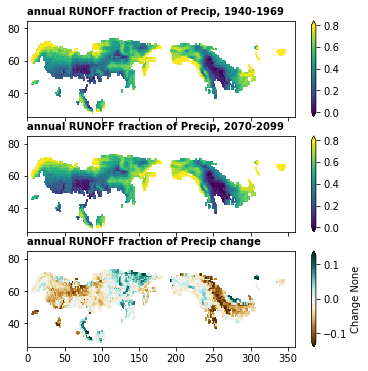

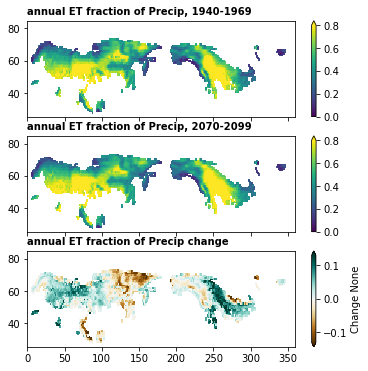

In [54]:
#ds_ann['WaterStress'] = ds_ann['WaterStress'].where(ds_ann['GPP']>0)
compare_plot(ds_ann['Run_frac'], vmin=0, vmax=0.8, cmap='BrBG') 
compare_plot(ds_ann['ET_frac'], vmin=0, vmax=0.8, cmap='BrBG') 
# same units for RunEff & Snow Frac, vmin=0, vmax=80, cmap='RdBu'
#compare_plot(ds_ann['SOILWATER_10CMwgt'], vmin=0., vmax=100., cmap='BrBG')

#compare_plot('WaterStress', vmin=10, vmax=200, cmap='RdBu_r') 
#compare_plot(ds_ann['BTRANMNwgt'], vmin=0.0, vmax=1.0, cmap='RdBu_r')
# positive values = increase in water stress

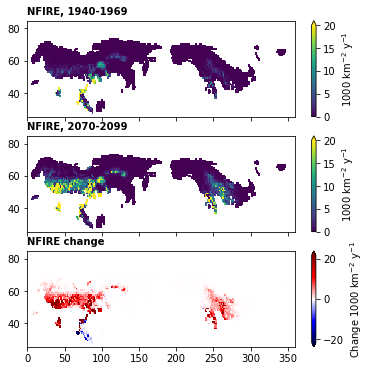

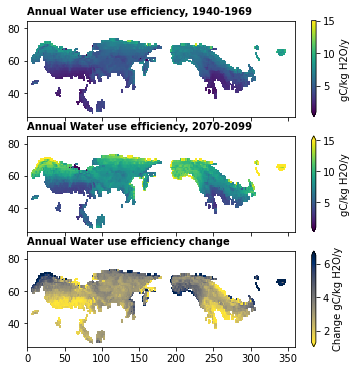

In [55]:
compare_plot(ds_ann['NFIRE'], vmin=0, vmax=20, cmap='seismic') 
compare_plot(ds_ann['WUE'], vmin=1, vmax=15, cmap='cividis_r')

-----
## *map_function*

In [56]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy

# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    #land = ax.add_feature(
    #    cfeature.NaturalEarthFeature('physical','land','110m', facecolor='grey',alpha=0.05))
    cmap = copy.copy(plt.get_cmap(cmap))
    cmap.set_bad( "gray", alpha=0.05 )
    #cmap.set_under( "white", alpha=1 )
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)

    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.04, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')


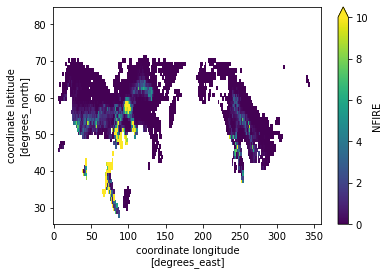

In [57]:
FINFIRE = ds_ann.NFIRE.mean(dim='ens').isel(year=slice(-30,None)).mean(dim='year')
INIFIRE = ds_ann.NFIRE.mean(dim='ens').isel(year=slice(90,120)).mean(dim='year')
INIFIRE.where(FINFIRE>0).plot(vmax=10) ;

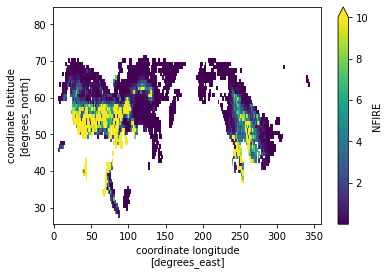

In [58]:
FINFIRE.where(FINFIRE>0).plot(vmax=10) ;


In [59]:
meanChange = (ds_ann.mean(dim='ens').isel(year=slice(-30,None)) \
                    .mean(dim='year') - \
              ds_ann.mean(dim='ens').isel(year=slice(90,120)) \
                    .mean(dim='year')).persist()

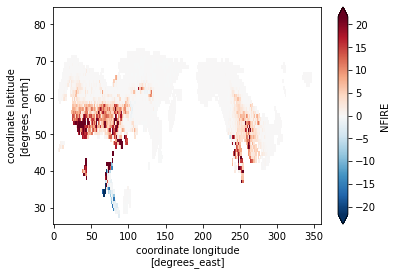

In [60]:
#fracChange = (ds_ann.mean(dim='ens').isel(year=slice(-30,None)) \
#                    .mean(dim='year') / \
#              ds_ann.mean(dim='ens').isel(year=slice(90,120)) \
#                    .mean(dim='year'))
fracChange = (meanChange / ds_ann.mean(dim='ens').isel(year=slice(90,120)).mean(dim='year')).persist()
meanChange.NFIRE.plot(robust=True) ;

In [61]:
summerChange = fin_weighted.isel(season=1).mean(dim='ens') - \
               ini_weighted.isel(season=1).mean(dim='ens')
summerChange = summerChange.where(
    ds_ann['GPP'].isel(year=slice(0,30)).mean(['ens','year'])>minGPP
).persist()

/glade/scratch/wwieder/VernalWindow/Fig2_MeanMaps.pdf


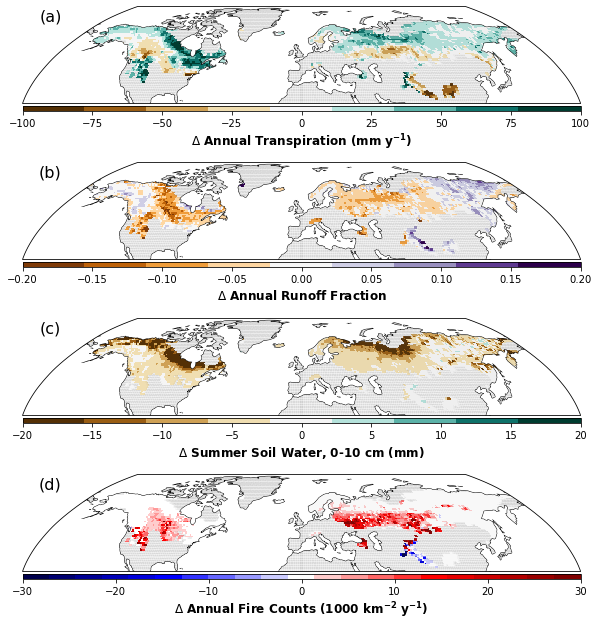

In [66]:
#---------------------
# Now call the map_function

panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(k)','(l)','(m)','(n)']  

# TRY MAKING SAME PLOTS W/ JUST 3 PANELS
pltVars = ['QVEGT','Run_frac','SOILWATER_10CM','NFIRE']
fout = ['Fig2_MeanMaps','FigSx6_','FigSx7_']
#fout = [i + j for i, j in zip(fout,pltVars)]  
for j in range(1):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,11), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
    #Define range, colorbar and units for variables

    for i in range(4):
        #i = index[0]
        if i ==0:
            dataIn =meanChange[pltVars[i]]
            vmin, vmax = -100,100
            cmap   = cm.get_cmap('BrBG', 9)  
            units  = r'$\Delta$ Annual Transpiration'+ \
                      ' ('+ds_ann[pltVars[i]].attrs['units']+')'

        if i ==1:
            dataIn = meanChange[pltVars[i]]
            vmin, vmax = -0.2,0.2
            cmap   = cm.get_cmap('PuOr', 9)  
            units  = r'$\Delta$ Annual Runoff Fraction'

        if i ==2:
            dataIn =summerChange[pltVars[i]]
            vmin, vmax = -20,20
            cmap   = cm.get_cmap('BrBG', 9)  
            units  = r'$\Delta$ Summer Soil Water, 0-10 cm (mm)'
            

        if i ==3:
            dataIn =meanChange[pltVars[i]] 
            vmin, vmax = -30,30
            cmap   = cm.get_cmap('seismic', 21)  
            units  = r'$\Delta$ Annual Fire Counts'+ \
                      ' ('+ds_ann[pltVars[i]].attrs['units']+')'
            #r'$\Delta $'+r' fire counts (1000 ${km^{-2}}$ ${y^{-1}}$)'#+ ds_ann.NFIRE.attrs['units']
            
        title  = r'$\Delta$ Change '+pltVars[i]

        # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
        map_function(dataIn, panel=panel[i], ax=axs[i],
                    vmax = vmax, vmin = vmin, cmap=cmap,
                    cb=1, units=units) 
    pathIN = '/glade/scratch/wwieder/VernalWindow/'
    fileOUT =  pathIN + fout[j]+'.pdf'
    print(fileOUT)
    #plt.savefig(fileOUT)


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)


/glade/scratch/wwieder/VernalWindow/FigS1_MeanMaps2.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


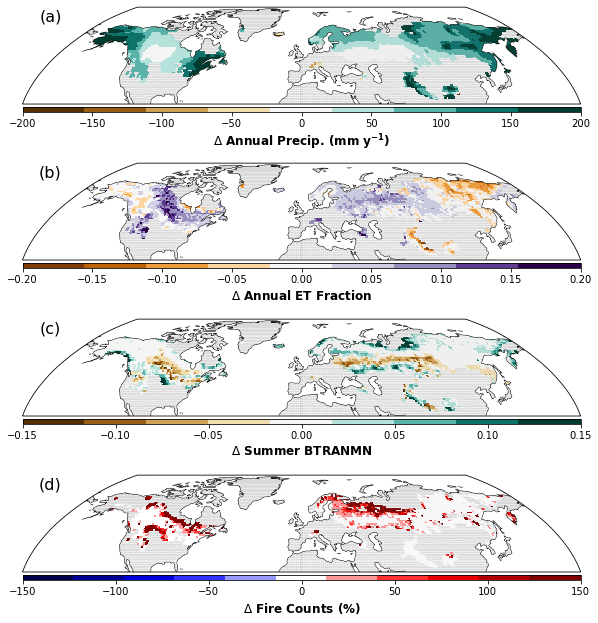

In [65]:
#---------------------
# TRY MAKING SAME PLOTS W/ JUST 3 PANELS
fout = ['FigS1_MeanMaps2']
pltVars = ['PRECIP','ET_frac','BTRANMN','NFIRE']
#fout = [i + j for i, j in zip(fout,pltVars)]  
for j in range(1):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,11), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

    #Define range, colorbar and units for variables
    for i in range(4):
        if i ==0:
            dataIn =meanChange[pltVars[i]]
            vmin, vmax = -200,200
            cmap   = cm.get_cmap('BrBG', 9)  
            units  = r'$\Delta$ Annual Precip. ('+ds_ann[pltVars[i]].attrs['units']+')'

        if i ==1:
            dataIn = meanChange[pltVars[i]]
            vmin, vmax = -0.2,0.2
            cmap   = cm.get_cmap('PuOr', 9)  
            units  = r'$\Delta$ Annual ET Fraction'

        if i ==2:
            dataIn =summerChange[pltVars[i]]
            vmin, vmax = -0.15,0.15
            cmap   = cm.get_cmap('BrBG', 9)  
            units  = r'$\Delta$ Summer BTRANMN'

        if i ==3:
            dataIn =fracChange[pltVars[i]]
            vmin, vmax = -150,150
            cmap   = cm.get_cmap('seismic', 11)  
            units  = r'$\Delta$ Fire Counts (%)' #+ ds.NFIRE.attrs['units']
        
        title  = r'$\Delta$ Change '+pltVars[i]

        # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
        map_function(dataIn, panel=panel[i], ax=axs[i],
                    vmax = vmax, vmin = vmin, cmap=cmap,
                    cb=1, units=units) 
    pathIN = '/glade/scratch/wwieder/VernalWindow/'
    fileOUT =  pathIN + fout[j]+'.pdf'
    print(fileOUT)
    #plt.savefig(fileOUT)


-----
### End of notebook 

In [67]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-08-05

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 0f44e29ab72e47d7cba042aa705c5a089f2d677a

Git repo: https://github.com/wwieder/cesm-lens.git

Git branch: main

matplotlib: 3.3.4
pandas    : 1.2.3
numba     : 0.52.0
numpy     : 1.20.1
cftime    : 1.4.1
dask      : 2021.6.2
scipy     : 1.6.0
cartopy   : 0.18.0
xarray    : 0.17.0



In [ ]:
x1 = ds_ann['Run_frac'].mean(dim='ens') \
                   .isel(year=slice(0,10)) \
                   .mean(dim='year')
x2 = ds_ann['Run_frac'].mean(dim='ens') \
                   .isel(year=slice(-10,None)) \
                   .mean(dim='year')
x3 = x2-x1
y1 = ds_ann['ET_frac'].mean(dim='ens') \
                   .isel(year=slice(0,10)) \
                   .mean(dim='year')
y2 = ds_ann['ET_frac'].mean(dim='ens') \
                   .isel(year=slice(-10,None)) \
                   .mean(dim='year')
y3 = y2-y1
y3 = y3.where(y3<50)
plt.scatter(x3,y3) 
#plt.ylim(-1,1);

In [ ]:
# Likely a better way to do this, area weighting ds_ann['RunEff'] over domain
#(100*ds_ann_glob['WaterStress']/ds_ann_glob['GPP']).plot(hue='ens',x='year') ;
plt.figure(figsize=[14,8])
plt.subplot(1,2,1)    
x = ds_ann_glob.year 
y = (100*ds_ann_glob['QRUNOFF']/ds_ann_glob['PRECIP']).mean(dim='ens') 
y2 = (100*ds_ann_glob['QRUNOFF']/ds_ann_glob['PRECIP']).std(dim='ens') 
plt.plot(x,y)
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel('Runoff Efficiency (%)') 


In [ ]:
### Changes in runoff may be clearer with monthly data?

In [ ]:
IniClimoMean = IniClimo.mean('ens').compute()
FinClimoMean = FinClimo.mean('ens').compute()

### Changes in July soil moisture (10 cm)

In [ ]:
# Number of snow free days
plotVar = 'SOILWATER_10CM'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1850',loc='left', fontsize='large', fontweight='bold')
IniClimoMean[plotVar].isel(month=6).plot(
    ax=ax1, vmax=80,vmin=20,
    cbar_kwargs={'label': "1850's July "+plotVar}) 
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
FinClimoMean[plotVar].isel(month=6).plot(
    ax=ax2, vmax=80,vmin=20 ,
    cbar_kwargs={'label': "2090's July "+plotVar}) 
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title('Change July soil water, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(FinClimoMean[plotVar]-IniClimoMean[plotVar]).isel(month=6).plot(
    ax=ax3, robust=True , cmap='RdBu',
    cbar_kwargs={'label': 'Chage July Soil Water'}) ;
ax3.set_xlabel('')
ax3.set_ylabel('') ;



### Changes in July BTRANMN

In [ ]:
# Number of snow free days
plotVar = 'BTRANMN'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1850',loc='left', fontsize='large', fontweight='bold')
IniClimoMean[plotVar].isel(month=6).plot(
    ax=ax1, vmax=1,vmin=0,
    cbar_kwargs={'label': "1850's July "+plotVar}) 
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
FinClimoMean[plotVar].isel(month=6).plot(
    ax=ax2, vmax=1,vmin=0 ,
    cbar_kwargs={'label': "2090's July "+plotVar}) 
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title('Change July BTRANMN, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(FinClimoMean[plotVar]-IniClimoMean[plotVar]).isel(month=6).plot(
    ax=ax3, robust=True , cmap='RdBu',
    cbar_kwargs={'label': 'Chage July BTRANMN'}) ;
ax3.set_xlabel('')
ax3.set_ylabel('') ;



-----
old code, not yet removed...

In [ ]:
# Number of snow free days
plotVar = 'WaterStress'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1850',loc='left', fontsize='large', fontweight='bold')
IniClimoMean[plotVar].isel(month=6).plot(
    ax=ax1, vmax=2,vmin=0,
    cbar_kwargs={'label': "1850's July "+plotVar}) 
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
FinClimoMean[plotVar].isel(month=6).plot(
    ax=ax2, vmax=2,vmin=0 ,
    cbar_kwargs={'label': "2090's July "+plotVar}) 
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
(FinClimoMean[plotVar]-IniClimoMean[plotVar]).isel(month=6).plot(
    ax=ax3, robust=True , cmap='BrBG_r',
    cbar_kwargs={'label': 'Chage July WaterStress'}) ;
ax3.set_xlabel('')
ax3.set_ylabel('') 
ax3.set_title('Change July WaterStress, 2100-1850',
              loc='left', fontsize='large', fontweight='bold') ;

_Why don't changes in soil water translate into BTRAN?_ 
* Do we need to look at deeper soil moisture?

In [ ]:
plotVar = 'BTRANMN'
simple=(FinClimoMean[plotVar]-IniClimoMean[plotVar]).plot(
    y='lat',x='lon',col="month", col_wrap=3,cmap='RdBu',robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.9,
        "aspect": 40,
        "pad": 0.07,
        "label": plotVar+" Change",
      }  # passed to plt.colorbar
)

In [ ]:
plotVar = 'SOILWATER_10CM'
simple=(FinClimoMean[plotVar]-IniClimoMean[plotVar]).plot(
    y='lat',x='lon',col="month", col_wrap=3,cmap='RdBu',robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.9,
        "aspect": 40,
        "pad": 0.07,
        "label": plotVar+" Change",
      }  # passed to plt.colorbar
)

In [ ]:
plotVar = 'WaterStress'
simple=(FinClimoMean[plotVar]-IniClimoMean[plotVar]).plot(
    y='lat',x='lon',col="month", col_wrap=3,cmap='BrBG_r',robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.9,
        "aspect": 40,
        "pad": 0.07,
        "label": plotVar+" Change",
      }  # passed to plt.colorbar
)

-------------
### End of Notebook

In [64]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-08-05

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 0f44e29ab72e47d7cba042aa705c5a089f2d677a

Git repo: https://github.com/wwieder/cesm-lens.git

Git branch: main

matplotlib: 3.3.4
pandas    : 1.2.3
numba     : 0.52.0
numpy     : 1.20.1
cftime    : 1.4.1
dask      : 2021.6.2
scipy     : 1.6.0
cartopy   : 0.18.0
xarray    : 0.17.0

